In [0]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import math as mt
from scipy.stats import norm

# Reading the data

In [0]:
df = pd.read_csv('cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


# Exploratory Data Analysis

In [0]:
df.shape[0]
df['userid'].nunique()
df['retention_1']=df['retention_1'].map({False: 0, True: 1 })
df['retention_7']=df['retention_7'].map({False: 0, True: 1 })
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
...,...,...,...,...,...
90184,9999441,gate_40,97,1,0
90185,9999479,gate_40,30,0,0
90186,9999710,gate_30,28,1,0
90187,9999768,gate_40,51,1,0


In [0]:
#Check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


In [0]:
#Looking at the split between test and cotrol groups
df.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


### Analyzing player behavior

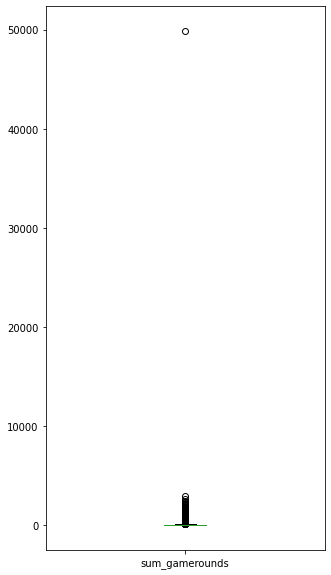

In [0]:
#Analyzing player level history
df['sum_gamerounds'].plot.box(figsize=(5,10))

In [0]:
#Removing the outlier
print (df['sum_gamerounds'].describe())
df = df[df.sum_gamerounds != 49854]

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64


Text(0.5, 0, '# Game rounds')

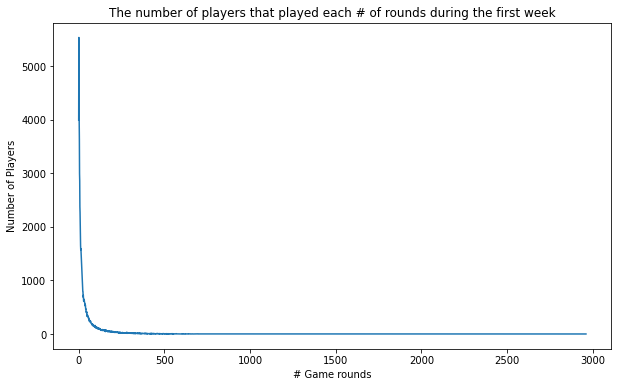

In [0]:
#Player level distribution
plot_df = df.groupby('sum_gamerounds')['userid'].count()
ax = plot_df[:].plot(figsize=(10,6))
ax.set_title("The number of players that played each # of rounds during the first week")
ax.set_ylabel("Number of Players")
ax.set_xlabel('# Game rounds')

Text(0.5, 0, '# Game rounds')

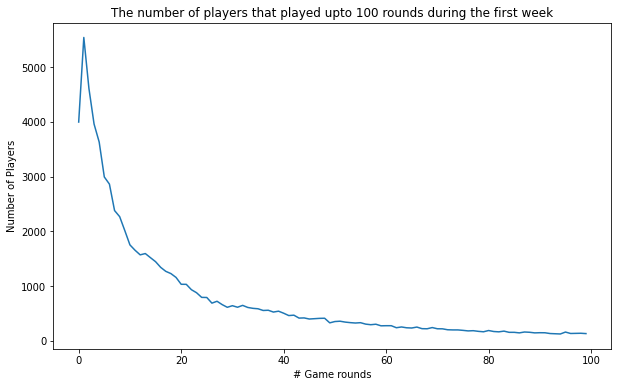

In [0]:
#Player level distribution - first 100
ax = plot_df[:100].plot(figsize=(10,6))
ax.set_title("The number of players that played upto 100 rounds during the first week")
ax.set_ylabel("Number of Players")
ax.set_xlabel('# Game rounds')

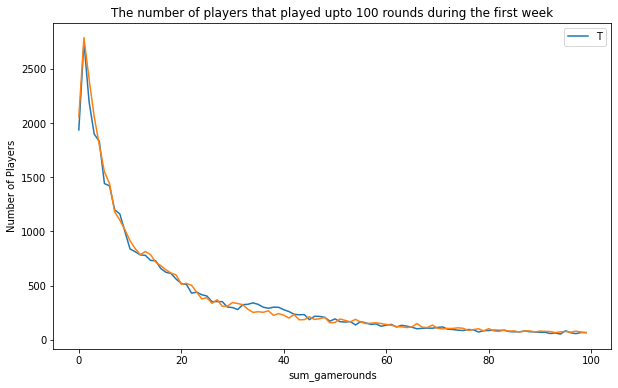

In [0]:
# Player level distribution by groups
ax = df[df.version == 'gate_30'].groupby('sum_gamerounds')['userid'].count()[:100].plot(figsize=(10,6))
ax.set_title("The number of players that played upto 100 rounds during the first week")
ax.set_ylabel("Number of Players")
ax.set_xlabel('# Game rounds')
ax.legend('C')
ax = df[df.version == 'gate_40'].groupby('sum_gamerounds')['userid'].count()[:100].plot(figsize=(10,6))
ax.legend('T')

From the above graphs we can see that some players never play the game after installing it, some players just play some games in the first week and some get hooked. We want the players to get hooked.

# Analysis

## Choosing metric

To check how likable and engaging the game is, we use 1-day retention. It is easier to retain players and build a large user base if the 1 day retention value is high

### Comparing 1-day retention

In [0]:
df['retention_1'].mean()

0.4452144409455803

One day retention shows that only little less than 50% of the players come back to play after installation

### A/B Testing using Boostrapping

Here we will check if the retention rate is different for the two AB groups

In [0]:
#Proportion of users converted in at 1-day for each AB group
print (df[df.version == 'gate_30']['retention_1'].mean())
print (df[df.version == 'gate_40']['retention_1'].mean())

0.4481979462627799
0.44228274967574577


We can see that there is a slight decrease in the 1 day retention when the gate is moved to level 40

Can be confident in the difference between the two AB groups?

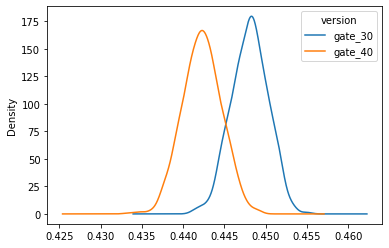

In [0]:
# Creating an list with bootstrapped means for each AB-group
boot_1d = []
for i in range(1000):
    boot_mean = df.sample(frac = 1,replace = True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
    
# A Kernel Density Estimate plot of the bootstrap distributions
boot_1d.plot(kind='density')

Probability that 1-day retention is greater when the gate is at level 30: 0.97


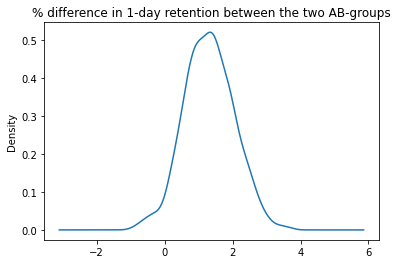

In [0]:
# Adding a column with the % difference between the two AB-groups
boot_1d['diff'] = (boot_1d.gate_30 - boot_1d.gate_40)/boot_1d.gate_40*100

# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot(kind='density')
ax.set_title('% difference in 1-day retention between the two AB-groups')

# Calculating the probability that 1-day retention is greater when the gate is at level 30
print('Probability that 1-day retention is greater when the gate is at level 30:',(boot_1d['diff'] > 0).mean())

### Comparing 7-day retention

In [0]:
#Proportion of users converted in at 7-day for each AB group
print (df[df.version == 'gate_30']['retention_7'].mean())
print (df[df.version == 'gate_40']['retention_7'].mean())

0.19018322557551623
0.18200004396667327


### A/B Testing using Boostrapping

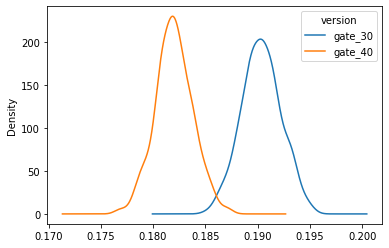

In [0]:
# Creating a list with bootstrapped means for each AB-group
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac=1,replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_7d = pd.DataFrame(boot_7d)

# A Kernel Density Estimate plot of the bootstrap distributions
boot_7d.plot(kind='density')

Probability that 7-day retention is greater when the gate is at level 30: 0.996


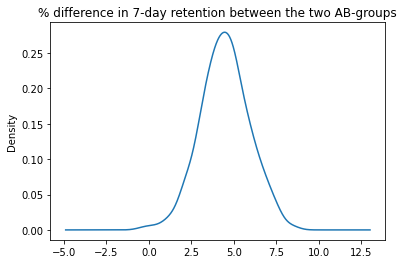

In [0]:
# Creating a list with bootstrapped means for each AB-group
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac=1,replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_7d = pd.DataFrame(boot_7d)

# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = (boot_7d.gate_30 - boot_7d.gate_40)/boot_7d.gate_40*100

# Ploting the bootstrap % difference
ax = boot_7d['diff'].plot(kind='density')
ax.set_title('% difference in 7-day retention between the two AB-groups')

# Calculating the probability that 7-day retention is greater when the gate is at level 30
print('Probability that 7-day retention is greater when the gate is at level 30:',(boot_7d['diff'] > 0).mean())

### A/B Testing using T-test

### 1 day retention

Calculating marginal error using standard error and z score

In [0]:
retention_day_1 = df.groupby('version')['retention_1'].sum()
user_table_day1 = df.groupby('version')['userid'].count()
retention_gate_30_day1=round((retention_day_1['gate_30']/user_table_day1['gate_30']),4)
retention_gate_40_day1=round((retention_day_1['gate_40']/user_table_day1['gate_40']),4)

In [0]:

p_pool_day1 = (retention_day_1['gate_30'] + retention_day_1['gate_40'])/(user_table_day1['gate_30']+user_table_day1['gate_40'])
p_pool_day1

0.4452144409455803

In [0]:
se_pool_day1=round(mt.sqrt(p_pool_day1*(1-p_pool_day1)*(1/user_table_day1['gate_30']+ 1/user_table_day1['gate_40'])),4)
se_pool_day1

0.0033

In [0]:
# For 95% confidence interval the value of Z is 1.96 either we can use Z score table or we can use scipy package to calculate it
alpha=0.05
z=round(norm.ppf(1-alpha/2),2)
#Marginal Error calculation
Marginal_Error=round((z*se_pool_day1),4)
Marginal_Error

0.0065

In [0]:
#The mean difference in the samples
p_difference = round((retention_gate_40_day1-retention_gate_30_day1),4)
p_difference

-0.0059

In [0]:
print ("The confidence interval is (%s, %s)" %(p_difference-Marginal_Error,p_difference+Marginal_Error))

The confidence interval is (-0.0124, 0.0005999999999999998)


In [0]:
t_statistic=p_difference-Marginal_Error
t_statistic

-0.0124

In [0]:
if t_statistic>0.05:
    print("Experiment performed better than control. It is statistically and practically significant")
elif t_statistic>0:
    print("Experiment performed better than control.It is statistically significant but not practically")
elif t_statistic<0:
    print("Control group is better than the Experiment group. Hence, No need to make changes. ")

Control group is better than the Experiment group. Hence, No need to make changes. 


In [0]:
#cohen's d
d=round((p_difference/se_pool_day1),2)
d

-1.79

### 7 day retention

In [0]:
retention_day_7=df.groupby('version')['retention_7'].sum() 
user_table_day7=df.groupby('version')['userid'].count()
retention_gate_30_day7=(retention_day_7['gate_30']/user_table_day7['gate_30'])
retention_gate_40_day7=(retention_day_7['gate_40']/user_table_day7['gate_40'])


In [0]:
p_pool_day7 = round((retention_day_7['gate_30'] + retention_day_7['gate_40'])/(user_table_day7['gate_30']+user_table_day7['gate_40']),4)
p_pool_day7

0.1861

In [0]:
se_pool_day7=round(mt.sqrt(p_pool_day7*(1-p_pool_day7)*((1/user_table_day7['gate_30']) + (1/user_table_day7['gate_40']))),4)
se_pool_day7

0.0026

In [0]:
# For 95% confidence interval the value of Z is 1.96
Marginal_Error_day7=z*se_pool_day7
Marginal_Error_day7

0.005096

In [0]:
p_difference = round((retention_gate_40_day7-retention_gate_30_day7),4)
p_difference

-0.0082

In [0]:
t_statistic_7=p_difference-Marginal_Error_day7
t_statistic_7

-0.013296

In [0]:
print ("The confidence interval is" ,p_difference-Marginal_Error_day7 ,"and", p_difference+Marginal_Error_day7,)

The confidence interval is -0.013296 and -0.003104000000000001


In [0]:
if t_statistic>0.05:
    print("Experiment performed better than control. It is statistically and practically significant")
elif t_statistic>0:
    print("Experiment performed better than control.It is statistically singnificant but not practically")
elif t_statistic<0:
    print("Control group is better than the Experiment group. Hence, No need to make changes ")

Control group is better than the Experiment group. Hence, No need to make changes 


In [0]:
#Cohen's d
d=p_difference/se_pool_day7
d

-3.153846153846154